## Use **Fuzzing Book** Resources

Clone the [Fuzzing Book](https://www.fuzzingbook.org/) repository and put this notebook under the directory `fuzzingbook/notebooks/`. Then you can use the fuzzing book resources in this notebook.

In [1]:
import sys
sys.path.append("notebooks/") # add the notebooks directory to the path

import bookutils
from typing import List, Tuple, Dict, Any
from Fuzzer import RandomFuzzer
from html.parser import HTMLParser
from Coverage import Coverage
import pickle
import hashlib

# **0. Preparation**

## Choose the target SUT & Initialize the fuzzer

### A program-under-test: HTML parser

In [2]:
def my_parser(inp: str) -> None:
    parser = HTMLParser()
    parser.feed(inp)

# Getting the coverage given the input
inp = "<html>"

with Coverage() as cov:
    my_parser(inp)
cov.coverage()

{('__init__', 92),
 ('__init__', 93),
 ('check_for_whole_start_tag', 352),
 ('check_for_whole_start_tag', 353),
 ('check_for_whole_start_tag', 354),
 ('check_for_whole_start_tag', 355),
 ('check_for_whole_start_tag', 356),
 ('check_for_whole_start_tag', 357),
 ('check_for_whole_start_tag', 358),
 ('feed', 109),
 ('feed', 110),
 ('goahead', 134),
 ('goahead', 135),
 ('goahead', 136),
 ('goahead', 137),
 ('goahead', 138),
 ('goahead', 139),
 ('goahead', 140),
 ('goahead', 160),
 ('goahead', 165),
 ('goahead', 166),
 ('goahead', 167),
 ('goahead', 168),
 ('goahead', 169),
 ('goahead', 170),
 ('goahead', 184),
 ('goahead', 198),
 ('goahead', 244),
 ('goahead', 250),
 ('handle_starttag', 431),
 ('my_parser', 2),
 ('my_parser', 3),
 ('parse_starttag', 301),
 ('parse_starttag', 302),
 ('parse_starttag', 303),
 ('parse_starttag', 305),
 ('parse_starttag', 306),
 ('parse_starttag', 309),
 ('parse_starttag', 310),
 ('parse_starttag', 311),
 ('parse_starttag', 312),
 ('parse_starttag', 313),
 ('p

### Create simple fuzzer: random string generator

In [3]:
fuzzer = RandomFuzzer(
    min_length=1, max_length=100, char_start=32, char_range=94
)
print("input 1:", fuzzer.fuzz())
print("input 2:", fuzzer.fuzz())
print("input 3:", fuzzer.fuzz())

input 1: "N&+slk%hyp5o'@[3(rW*M5W]tMFPU4\P@tz%[X?uo\1?b4T;1bDeYtHx #UJ5w}pMmPodJM,_%%
input 2: CdYN6*g|Y*Ou9I<P94}7,99ivb(9`=%jJj*
input 3: *dOLXk!;Jw!iOU8]hqg00?u(c);>:\=V<ZV1=*g#UJA'No5QZ)--[})Sdv


### Ease of use: Coverage $\rightarrow$ Hexstring (hashing) (:= a color of a ball)

In [34]:
# Coverage -> hexstring (a colored ball)
def getCovHash(cov: Coverage) -> str:
    pickledCov = pickle.dumps(cov.coverage())
    hashedCov = hashlib.md5(pickledCov).hexdigest()
    return hashedCov

covlist = list(cov.coverage())
print(
f"The coverage [{covlist[0]}\n"
f"              {covlist[1]}\n"
f"              {covlist[2]}\n"
f"              {covlist[3]}\n"
f"              {covlist[4]}\n"
f"              ...]")
print(f"is converted to the color {getCovHash(cov)}.")

The coverage [('parse_starttag', 303)
              ('goahead', 139)
              ('parse_starttag', 309)
              ('parse_starttag', 306)
              ('parse_starttag', 312)
              ...]
is converted to the color 753777300cd8df82c2c50eabec699faa.


### **The rarity differs for different coverage (color)**

#### First 10 samples (= coverage from execution)

In [35]:
# n: number of samples
n = 10
print(f"{n} samples from the urn:")
for i in range(n):
    inp = fuzzer.fuzz()
    with Coverage() as cov:
        my_parser(inp)
    print(f"| sample {i + 1:2d}th: {getCovHash(cov)}")

10 samples from the urn:
| sample  1th: bbef24643646b0743d0449bc07a01467
| sample  2th: 7ac31f974811784e85c87e26096f8223
| sample  3th: f741deb3b675d16bebee31dc0303f06b
| sample  4th: cdcc675f447046cc52b8ee0bb0ae7809
| sample  5th: 7ac31f974811784e85c87e26096f8223
| sample  6th: 7ac31f974811784e85c87e26096f8223
| sample  7th: cdcc675f447046cc52b8ee0bb0ae7809
| sample  8th: cdcc675f447046cc52b8ee0bb0ae7809
| sample  9th: cdcc675f447046cc52b8ee0bb0ae7809
| sample 10th: cdcc675f447046cc52b8ee0bb0ae7809


#### Distribution of frequencies of colors (n = 10,000)

In [36]:
# n: number of samples
n = 10000

# Population of inputs
population = []
for i in range(n):
    population.append(fuzzer.fuzz())

# Record the frequency of each coverage
all_coverage_dict = {}
for inp in population:
    with Coverage() as cov:
        try:
            my_parser(inp)
        except BaseException:
            pass
    cov_hash = getCovHash(cov)
    if cov_hash not in all_coverage_dict:
        all_coverage_dict[cov_hash] = 0
    all_coverage_dict[cov_hash] += 1

Number of unique color: 227
Top 3 frequencies: [4026, 1143, 1076]
Bottom 3 frequencies: [1, 1, 1]


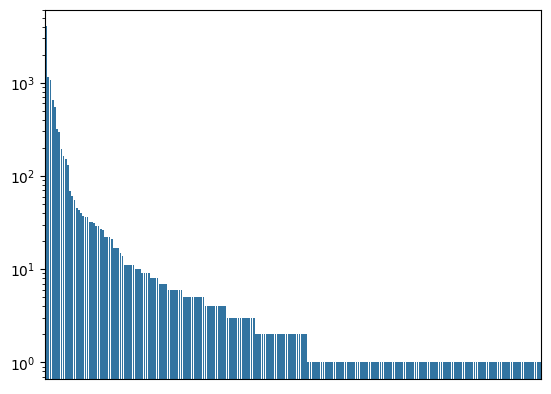

In [37]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

num_unique = len(all_coverage_dict)
print(f"Number of unique color: {num_unique}")
print(
    f"Top 3 frequencies: {sorted(list(all_coverage_dict.values()), reverse=True)[:3]}"
)
print(f"Bottom 3 frequencies: {sorted(list(all_coverage_dict.values()))[:3]}")
freqs = sorted(list(all_coverage_dict.values()), reverse=True)
# print bar chart of the frequencies
fig, ax = plt.subplots()
sns.barplot(x=list(range(len(freqs))), y=freqs, ax=ax)
# remove the x labels
ax.set_xticks([])
# set log-scale for y-axis
ax.set_yscale("log")
plt.show()

## Some Definitions

- Singletons: colors that appear only once in the sample
- Doubletons: colors that appear twice in the sample

$$
\Phi_k = \text{the number of colors that appear $k$ times in the sample}
$$

- $\Phi_1$ = the number of singletons, $\Phi_2$ = the number of doubletons, etc.

In [38]:
##### Num. of Singletons & Doubletons ####
singletons = {k: v for k, v in all_coverage_dict.items() if v == 1}
doubletons = {k: v for k, v in all_coverage_dict.items() if v == 2}
##########################################

print(
    "The number of color seen exactly once is "
    + str(len(singletons))
)
print(
    "The number of color seen exactly twice is "
    + str(len(doubletons))
)

The number of color seen exactly once is 107
The number of color seen exactly twice is 24


***💡 Go back to the slides***

# **Missing Mass**: What is the probability that the next input will have a new coverage?

## Good-Turing estimator

$$
\hat{M}_0^{\text{GoodTuring}} = \frac{\Phi_1}{n},
$$

where $\Phi_1$ is the number of singletons.

In [39]:
# TODO: Implement the Good-Turing estimator

############### Good-Turing ##############
estimate = len(singletons) / n
##########################################

print(
    f"The probability that the next sample has a new color is estimated as {estimate} ({len(singletons)} / {n}).\n"
    f"      (= the probability of observing a new coverage)\n"
)

The probability that the next sample has a new color is estimated as 0.0107 (107 / 10000).
      (= the probability of observing a new coverage)



## How do we evaluate this?

### Evaluate the estimator empirically

We run the fuzzer for additional number of iterations (e.g., n = 10,000) and check how many new coverages we actually get.

In [42]:
######### Empirical Evaluation ##########
curr_coverage = all_coverage_dict.keys()

count = 0
validation = []
for i in range(n):  # sample the same number of inputs as in the population
    validation.append(fuzzer.fuzz())

for inp in validation:
    with Coverage() as cov:
        try:
            my_parser(inp)
        except BaseException:
            pass
    this_coverage = set([getCovHash(cov)])
    if len(curr_coverage & this_coverage) == 0:
        count = count + 1

empirical = count / n
##########################################

print(
    f"The empirically probability that the next sample has a new color from {n} additional samples is {empirical} ({count} / {n}).\n"
)
print(f"Good-Turing estimate : {estimate}")
print(f"Empirical probability: {empirical}")

The empirically probability that the next sample has a new color from 10000 additional samples is 0.011 (110 / 10000).

Good-Turing estimate : 0.0107
Empirical probability: 0.011


### Let's go up to n = 100,000 and compare the **Good-Turing estimator** with the **empirical missing mass**.

In [43]:
import numpy as np

n = 200000
samples = []
for i in range(n):
    inp = fuzzer.fuzz()
    with Coverage() as cov:
        try:
            my_parser(inp)
        except BaseException:
            pass
    cov_hash = getCovHash(cov)
    samples.append(cov_hash)

xs = np.logspace(2, 5, 100)
xs = [int(x) for x in xs]
es = []
ps = []
for x in xs:
    seen_freq_dict = dict(zip(*np.unique(samples[:x], return_counts=True)))
    seens = set(seen_freq_dict.keys())
    remain_freq_dict = dict(zip(*np.unique(samples[x:], return_counts=True)))
    unseens = set(remain_freq_dict.keys()) - seens
    num_unseen = np.sum([remain_freq_dict[unseen] for unseen in unseens])
    ps.append(num_unseen / (n - x))
    singletons = {k: v for k, v in seen_freq_dict.items() if v == 1}
    es.append(len(singletons) / x)

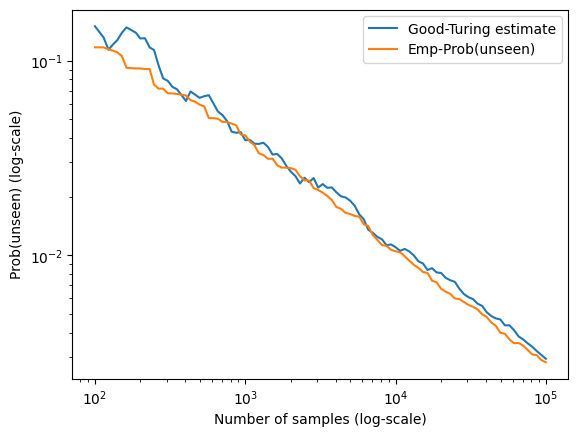

In [44]:
fig, ax = plt.subplots()
ax.plot(xs, es, label="Good-Turing estimate")
ax.plot(xs, ps, label="Emp-Prob(unseen)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of samples (log-scale)")
ax.set_ylabel("Prob(unseen) (log-scale)")
ax.legend()
plt.show()

***💡 Go back to the slides :)***

# **Extrapolation**: How much can I discover more when I spend $X$ more time here?

- $\Delta(m)$: the number of new discoveries when $m$ more samples are retrieved.

$$
\hat \Delta(m) = \hat \Phi_0 \left[1 - \left(1 - \frac{\Phi_1}{n\hat \Phi_0 + \Phi_1} \right)^m\right]
$$

## What I'm going to do:

### 1. **Initial sample of size 200,000:** Check the coverage incrase & Count the number of **singletons** ($\Phi_1$) and **doubletons** ($\Phi_2$).
### 2. **Extrapolation:** Estimate how the coverage discovery will increase for the **next 200,000 samples** with the estimator above.
### 3. **Comparison with the empirical result:** Actually getting 200,000 samples more and see how the coverage discovery empirically increases.


In [45]:
############################################################
# First 200,000 inputs => Initial sample data
############################################################
n = 200000
population = []
for i in range(n):
    population.append(fuzzer.fuzz())

cumulative_coverage = []
all_coverage = set()
singletons = set()  # Store the number of singletons 
doubletons = set()  # and doubletons for the extrapolation

for inp in population:
    with Coverage() as cov:
        try:
            my_parser(inp)
        except BaseException:
            pass
    this_coverage = set([getCovHash(cov)])
    doubletons -= this_coverage
    doubletons |= singletons & this_coverage
    singletons -= this_coverage
    singletons |= this_coverage - all_coverage
    all_coverage |= this_coverage
    cumulative_coverage.append(len(all_coverage))

# Number of singletons and doubletons from the first 200,000 inputs
# => Used for extrapolation
num_singletons = len(singletons)
num_doubletons = len(doubletons)

############################################################
# Additional 200,000 inputs => Validation data (not used for extrapolation)
############################################################
extra_n = 200000
validation = []
for i in range(extra_n):
    validation.append(fuzzer.fuzz())

for inp in validation:
    with Coverage() as cov:
        try:
            my_parser(inp)
        except BaseException:
            pass
    this_coverage = set([getCovHash(cov)])
    all_coverage |= this_coverage
    cumulative_coverage.append(len(all_coverage))


### **1) How the coverage increases with the first 200,000 samples**

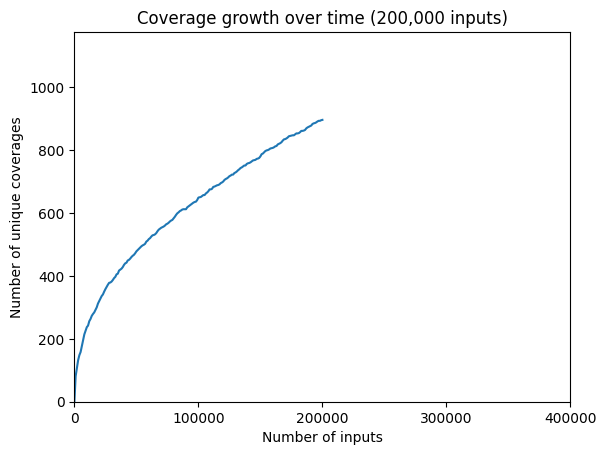

In [46]:
fig, ax = plt.subplots()
coverage_ateach_1000trial = [0] + cumulative_coverage[
    999::1000
]  # for every 1000 trials
sub_coverage_until_half = coverage_ateach_1000trial[:201]
sns.lineplot(
    x=range(0, n + 1, 1000),
    y=sub_coverage_until_half,
    ax=ax,
)
ax.set_xlim(0, 2 * n)
ax.set_ylim(0, cumulative_coverage[-1])
ax.set_xticks([0, n / 2, n, n * 3 / 2, 2 * n])
ax.set_xlabel("Number of inputs")
ax.set_ylabel("Number of unique coverages")
ax.set_title("Coverage growth over time (200,000 inputs)")
plt.show()

### **2) Extrapolation of the coverage increase for the next 200,000 samples**

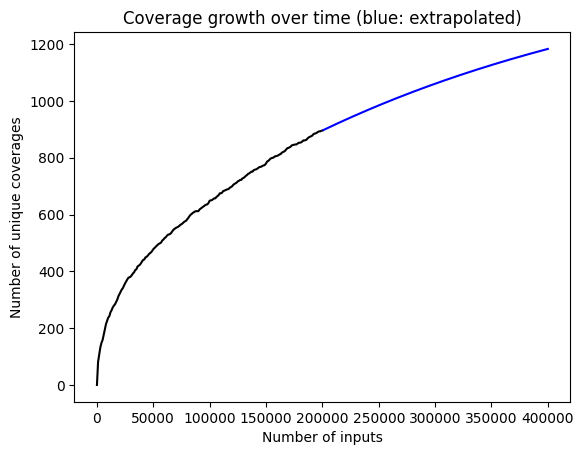

In [47]:
## formula:
## - \Phi_0 = (n - 1) / n * (\Phi_1^2 / (2 \Phi_2))
## - \Delta(m) = \Phi_0 [1 - (1 - \Phi_1/(n \Phi_0 + \Phi_1) )^m ]

############# IMPLEMENT HERE #############
phi1 = num_singletons
phi2 = num_doubletons
phi0 = (n - 1) / n * (phi1**2 / (2 * phi2))
extrapolator = lambda m: phi0 * (1 - (1 - phi1 / (n * phi0 + phi1)) ** m)

extrapolated = [extrapolator(i) for i in range(1, n + 1)]
extrapolated = [delta + sub_coverage_until_half[-1] for delta in extrapolated]
##########################################

fig, ax = plt.subplots()
sns.lineplot(
    x=range(0, n + 1, 1000),
    y=sub_coverage_until_half,
    ax=ax,
    color="black",
)
sns.lineplot(
    x=range(n + 1000, n * 2 + 1, 1000),
    y=extrapolated[999::1000],
    ax=ax,
    color="blue",
    dashes=True,
)
ax.set_xlabel("Number of inputs")
ax.set_ylabel("Number of unique coverages")
ax.set_title("Coverage growth over time (blue: extrapolated)")

plt.show()

### **3) Comparison: Extrapolate vs. How the coverage increases empirically with the next 200,000 samples**

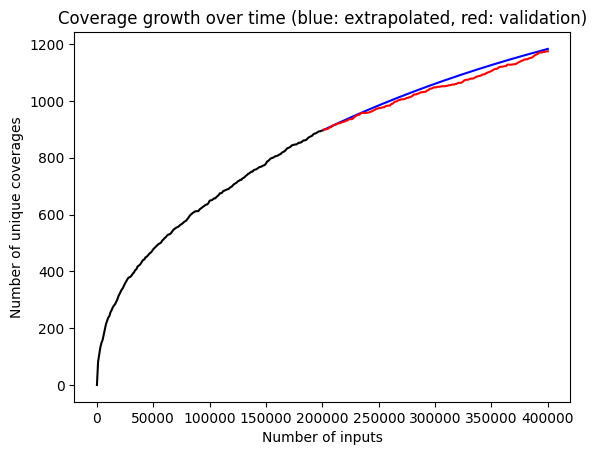

In [48]:
fig, ax = plt.subplots()
sns.lineplot(
    x=range(0, n + 1, 1000),
    y=sub_coverage_until_half,
    ax=ax,
    color="black",
)
sns.lineplot(
    x=range(n + 1000, n * 2 + 1, 1000),
    y=extrapolated[999::1000],
    ax=ax,
    color="blue",
    dashes=True,
)
sns.lineplot(
    x=range(n + 1000, n * 2 + 1, 1000),
    y=coverage_ateach_1000trial[201:],
    ax=ax,
    color="red",
)
ax.set_xlabel("Number of inputs")
ax.set_ylabel("Number of unique coverages")
ax.set_title("Coverage growth over time (blue: extrapolated, red: validation)")
plt.show()

***💡 Go back to the slides***